In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="2"


In [3]:
# there are two environments(debug and prod). From where you want to fetch the code and data? 
DEBUG=False

In [4]:
%run ./nb_core/root_dirs.ipynb
setup_syspath_disentangle(DEBUG)
%run ./nb_core/disentangle_imports.ipynb

DATA_ROOT:	 /group/jug/ashesh/data/
CODE_ROOT:	 /home/ashesh.ashesh/


In [5]:
# 'stats_'+'_'.join(ckpt_dir.split('/')[-4:]) + '.pkl'

In [6]:
ckpt_dir = "/home/ashesh.ashesh/training/disentangle/2311/D7-M23-S0-L0/8"
# 211/D3-M3-S0-L0/0
# 2210/D3-M3-S0-L0/128
# 2210/D3-M3-S0-L0/129

In [7]:
# !ls /home/ubuntu/ashesh/training/disentangle/2209/D3-M9-S0-L0/1

In [8]:
dtype = int(ckpt_dir.split('/')[-2].split('-')[0][1:])

In [9]:
dtype

7

In [10]:
if DEBUG:
    if dtype == DataType.CustomSinosoid:
        data_dir = f'{DATA_ROOT}/sinosoid/'
    elif dtype == DataType.OptiMEM100_014:
        data_dir = f'{DATA_ROOT}/microscopy/'
else:
    if dtype in [DataType.CustomSinosoid, DataType.CustomSinosoidThreeCurve]:
        data_dir = f'{DATA_ROOT}/sinosoid_without_test/sinosoid/'
    elif dtype == DataType.OptiMEM100_014:
        data_dir = f'{DATA_ROOT}/microscopy/'
    elif dtype == DataType.Prevedel_EMBL:
        data_dir = f'{DATA_ROOT}/Prevedel_EMBL/PKG_3P_dualcolor_stacks/NoAverage_NoRegistration/'
    elif dtype == DataType.AllenCellMito:
        data_dir = f'{DATA_ROOT}/allencell/2017_03_08_Struct_First_Pass_Seg/AICS-11/'
    elif dtype == DataType.SeparateTiffData:
        data_dir = f'{DATA_ROOT}/ventura_gigascience'
    elif dtype == DataType.SemiSupBloodVesselsEMBL:
        data_dir = f'{DATA_ROOT}/EMBL_halfsupervised/Demixing_3P'
    elif dtype == DataType.Pavia2VanillaSplitting:
        data_dir = f'{DATA_ROOT}/pavia2'
    elif dtype == DataType.ExpansionMicroscopyMitoTub:
        data_dir = f'{DATA_ROOT}/expansion_microscopy_Nick/'
    elif dtype == DataType.ShroffMitoEr:
        data_dir = f'{DATA_ROOT}/shrofflab/'
    elif dtype == DataType.HTIba1Ki67:
        data_dir = f'{DATA_ROOT}/Stefania/20230327_Ki67_and_Iba1_trainingdata/'
    elif dtype == DataType.BioSR_MRC:
        data_dir = f'{DATA_ROOT}/BioSR/'
        
#     2720*2720: microscopy dataset.

image_size_for_grid_centers = 32
mmse_count = 5
custom_image_size = 64
denoise_channel = 'Ch2'


batch_size = 8
num_workers = 4
COMPUTE_LOSS = False
use_deterministic_grid = None
threshold = None # 0.02
compute_kl_loss = False
evaluate_train = False# inspect training performance
eval_datasplit_type = DataSplitType.Test
val_repeat_factor = None
psnr_type = 'range_invariant' #'simple', 'range_invariant'

In [11]:
%run ./nb_core/config_loader.ipynb

data:
  background_quantile: 0.0
  ch1_fname: actin-60x-noise2-lowsnr.tif
  ch2_fname: mito-60x-noise2-lowsnr.tif
  channel_1: 0
  channel_2: 1
  clip_background_noise_to_zero: false
  clip_percentile: 0.995
  data_type: 7
  deterministic_grid: false
  enable_poisson_noise: false
  grid_size: 32
  image_size: 64
  input_is_sum: false
  multiscale_lowres_count: null
  normalized_input: true
  padding_mode: reflect
  padding_value: null
  randomized_channels: false
  sampler_type: 0
  skip_normalization_using_mean: false
  target_separate_normalization: false
  train_aug_rotate: false
  use_one_mu_std: true
  val_grid_size: 32
datadir: /group/jug/ashesh/data/ventura_gigascience/
exptname: 2311/D7-M23-S0-L0/8
git:
  branch: master
  changedFiles:
  - disentangle/notebooks/EvalOnMultiFileDataset.ipynb
  - disentangle/notebooks/EvalOnWholeFrames.ipynb
  - disentangle/notebooks/nb_core/disentangle_setup.ipynb
  latest_commit: 9012fd7778193bb139d427513532a5aaeede1aaa
  untracked_files:
  - di

In [12]:
data_dir

'/group/jug/ashesh/data//ventura_gigascience'

In [13]:
# config.model.decoder

In [14]:
from disentangle.core.sampler_type import SamplerType
from disentangle.core.loss_type import LossType
from disentangle.data_loader.ht_iba1_ki67_rawdata_loader import SubDsetType
# from disentangle.core.lowres_merge_type import LowresMergeType


with config.unlocked():
    if denoise_channel is not None:
        config.model.denoise_channel = denoise_channel
        
    config.model.skip_nboundary_pixels_from_loss = None
    if config.model.model_type == ModelType.UNet and 'n_levels' not in config.model:
        config.model.n_levels = 4
    if config.data.sampler_type == SamplerType.NeighborSampler:
        config.data.sampler_type = SamplerType.DefaultSampler
        config.loss.loss_type = LossType.Elbo
        config.data.grid_size = config.data.image_size
    if 'ch1_fpath_list' in config.data:
        config.data.ch1_fpath_list = config.data.ch1_fpath_list[:1]
        config.data.mix_fpath_list = config.data.mix_fpath_list[:1]
    if config.data.data_type == DataType.Pavia2VanillaSplitting:
        if 'channel_2_downscale_factor' not in config.data:
            config.data.channel_2_downscale_factor = 1
    if config.model.model_type == ModelType.UNet and 'init_channel_count' not in config.model:
        config.model.init_channel_count = 64
    
    if 'skip_receptive_field_loss_tokens' not in config.loss:
        config.loss.skip_receptive_field_loss_tokens = []
    
    if dtype == DataType.HTIba1Ki67:
        config.data.subdset_type = SubDsetType.Iba1Ki64
        config.data.empty_patch_replacement_enabled = False
    
    if 'lowres_merge_type' not in config.model.encoder:
        config.model.encoder.lowres_merge_type = 0

In [15]:
%run ./nb_core/disentangle_setup.ipynb


<class 'disentangle.data_loader.vanilla_dloader.MultiChDloader'>
Loading from /group/jug/ashesh/data//ventura_gigascience Channel1: /group/jug/ashesh/data//ventura_gigascience/actin-60x-noise2-lowsnr.tif,/group/jug/ashesh/data//ventura_gigascience/mito-60x-noise2-lowsnr.tif, Mode:Train
[MultiChDloader] Sz:64 Train:1 N:28 NumPatchPerN:4096 NormInp:True SingleNorm:True Rot:False RandCrop:False Q:0.995 SummedInput:False ReplaceWithRandSample:False BckQ:0.0
Loading from /group/jug/ashesh/data//ventura_gigascience Channel1: /group/jug/ashesh/data//ventura_gigascience/actin-60x-noise2-lowsnr.tif,/group/jug/ashesh/data//ventura_gigascience/mito-60x-noise2-lowsnr.tif, Mode:Test
[MultiChDloader] Sz:64 Train:0 N:3 NumPatchPerN:4096 NormInp:True SingleNorm:True Rot:False RandCrop:False Q:0.995 SummedInput:False ReplaceWithRandSample:False BckQ:0.0

config.pkl
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnable

In [16]:
len(train_dset)

114688

In [17]:
if config.data.multiscale_lowres_count is not None and custom_image_size is not None:
    model.reset_for_different_output_size(custom_image_size)

In [18]:
# if config.model.model_type not in [ModelType.UNet, ModelType.BraveNet]:
#     with torch.no_grad():
#         inp, tar = val_dset[0][:2]
#         out, td_data = model(torch.Tensor(inp[None]).cuda())
#         print(td_data['z'][-1].shape)
#         print(out.shape)

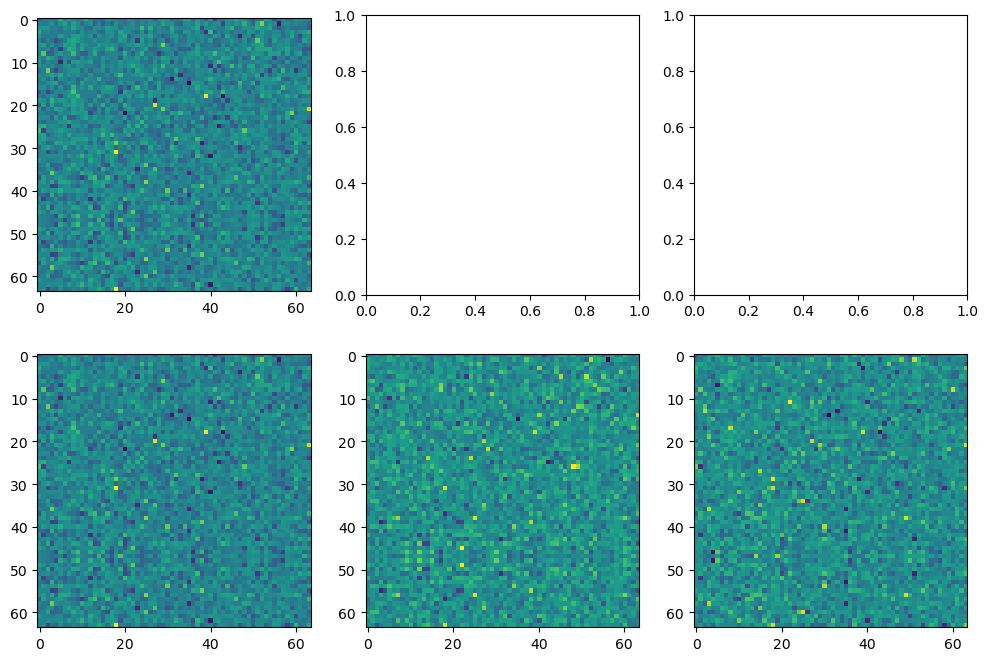

In [19]:
idx = np.random.randint(len(val_dset))
inp_tmp, tar_tmp, *_ = val_dset[idx]
ncols = max(len(inp_tmp),3)
nrows = 2
_,ax = plt.subplots(figsize=(4*ncols,4*nrows),ncols=ncols,nrows=nrows)
for i in range(len(inp_tmp)):
    ax[0,i].imshow(inp_tmp[i])

ax[1,0].imshow(tar_tmp[0]+tar_tmp[1])
ax[1,1].imshow(tar_tmp[0])
ax[1,2].imshow(tar_tmp[1])


In [20]:
model.data_mean['target']

tensor([[[[104.7661]]]], device='cuda:0')

In [21]:
from disentangle.analysis.stitch_prediction import stitch_predictions
from disentangle.analysis.mmse_prediction import get_dset_predictions
# from disentangle.analysis.stitch_prediction import get_predictions as get_dset_predictions

pred_tiled, rec_loss, logvar, patch_psnr_tuple = get_dset_predictions(model, val_dset,batch_size,
                                               num_workers=num_workers,
                                               mmse_count=mmse_count,
                                                model_type = config.model.model_type,
                                              )
assert patch_psnr_tuple[1] is None
print('Patch wise PSNR, as computed during training', np.round(patch_psnr_tuple[0].item(),2))

100%|██████████| 1536/1536 [02:24<00:00, 10.60it/s]

Patch wise PSNR, as computed during training 26.2


In [22]:
len(val_dset)

12288

In [23]:
idx_list = np.where(logvar.squeeze() < -6)[0]
if len(idx_list) > 0:
    plt.imshow(val_dset[idx_list[0]][1][1])

In [24]:
len(val_dset)

12288

/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

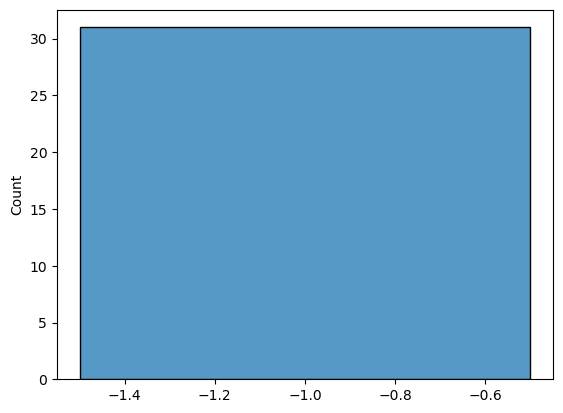

In [25]:
import seaborn as sns
sns.histplot(logvar[::50].squeeze().reshape(-1,))

In [26]:
print(np.quantile(rec_loss, [0,0.01,0.5, 0.9,0.99,0.999,1]).round(2))

[0.21 0.21 0.24 0.31 0.38 0.4  0.41]


In [27]:
pred_tiled.shape

(12288, 1, 64, 64)

In [28]:
len(val_dset)

12288

In [29]:
if pred_tiled.shape[-1] != val_dset.get_img_sz():
    pad = (val_dset.get_img_sz() - pred_tiled.shape[-1] )//2
    pred_tiled = np.pad(pred_tiled, ((0,0),(0,0),(pad,pad),(pad,pad)))

pred = stitch_predictions(pred_tiled,val_dset, smoothening_pixelcount=0)

In [30]:
pred_tiled.shape

(12288, 1, 64, 64)

In [31]:
pred.shape

(3, 2048, 2048, 2)

In [32]:
pred[np.isnan(pred)] = 0

In [33]:
def print_ignored_pixels():
    ignored_pixels = 1
    while(pred[0,-ignored_pixels:,-ignored_pixels:,].std() ==0):
        ignored_pixels+=1
    ignored_pixels-=1
    print(f'In {pred.shape}, last {ignored_pixels} many rows and columns are all zero.')
    return ignored_pixels

actual_ignored_pixels = print_ignored_pixels()

In (3, 2048, 2048, 2), last 0 many rows and columns are all zero.


## Ignore the pixels which are present in the last few rows and columns. 
1. They don't come in the batches. So, in prediction, they are simply zeros. So they are being are ignored right now. 
2. For the border pixels which are on the top and the left, overlapping yields worse performance. This is becuase, there is nothing to overlap on one side. So, they are essentially zero padded. This makes the performance worse. 

In [34]:
actual_ignored_pixels

0

In [35]:
if config.data.data_type in [DataType.OptiMEM100_014,
                                                      DataType.SemiSupBloodVesselsEMBL, 
                                                      DataType.Pavia2VanillaSplitting,
                                                      DataType.ExpansionMicroscopyMitoTub,
                                                      DataType.ShroffMitoEr,
                                                      DataType.HTIba1Ki67]:
    ignored_last_pixels = 32 
elif config.data.data_type == DataType.BioSR_MRC:
    ignored_last_pixels = 44
    assert val_dset.get_img_sz() == 64
else:
    ignored_last_pixels = 0

ignore_first_pixels = 0

assert actual_ignored_pixels <= ignored_last_pixels, f'Set ignored_last_pixels={actual_ignored_pixels}'
print(ignored_last_pixels)

0


In [36]:
val_dset._data.shape

(3, 2048, 2048, 2)

In [37]:
if model.denoise_channel == 'Ch1':
    tar = val_dset._data[...,:1]
elif model.denoise_channel == 'Ch2':
    tar = val_dset._data[...,1:]
elif model.denoise_channel == 'input':
    tar = np.mean(val_dset._data, axis=-1, keepdims=True)
    

def ignore_pixels(arr):
    if ignore_first_pixels:
        arr = arr[:,ignore_first_pixels:,ignore_first_pixels:]
    if ignored_last_pixels:
        arr = arr[:,:-ignored_last_pixels,:-ignored_last_pixels]
    return arr

pred = ignore_pixels(pred)
tar = ignore_pixels(tar)


In [38]:
from skimage.metrics import structural_similarity

def _avg_psnr(target, prediction, psnr_fn):
    output = np.mean([psnr_fn(target[i:i + 1], prediction[i:i + 1]).item() for i in range(len(prediction))])
    return round(output, 2)


def avg_range_inv_psnr(target, prediction):
    return _avg_psnr(target, prediction, RangeInvariantPsnr)


def avg_psnr(target, prediction):
    return _avg_psnr(target, prediction, PSNR)


def compute_masked_psnr(mask, tar1, tar2, pred1, pred2):
    mask = mask.astype(bool)
    mask = mask[..., 0]
    tmp_tar1 = tar1[mask].reshape((len(tar1), -1, 1))
    tmp_pred1 = pred1[mask].reshape((len(tar1), -1, 1))
    tmp_tar2 = tar2[mask].reshape((len(tar2), -1, 1))
    tmp_pred2 = pred2[mask].reshape((len(tar2), -1, 1))
    psnr1 = avg_range_inv_psnr(tmp_tar1, tmp_pred1)
    psnr2 = avg_range_inv_psnr(tmp_tar2, tmp_pred2)
    return psnr1, psnr2

def avg_ssim(target, prediction):
    ssim = [structural_similarity(target[i],prediction[i], data_range=(target[i].max() - target[i].min())) for i in range(len(target))]
    return np.mean(ssim),np.std(ssim)

In [39]:
sep_mean, sep_std = model.data_mean, model.data_std
if isinstance(sep_mean, dict):
    sep_mean = sep_mean['target']
    sep_std = sep_std['target']

if isinstance(sep_mean, int):
    pass
else:
    sep_mean = sep_mean.squeeze()[None,None,None]
    sep_std = sep_std.squeeze()[None,None,None]
    sep_mean = sep_mean.cpu().numpy() 
    sep_std = sep_std.cpu().numpy()

tar_normalized = (tar - sep_mean)/ sep_std

In [40]:
q_vals = [0.01, 0.1,0.5,0.9,0.95, 0.99,1]
print(np.quantile(tar_normalized[...,0], q_vals).round(2))

[-1.88 -1.02 -0.16  0.69  1.34  2.63  5.2 ]


In [41]:
print(np.quantile(tar[...,0], q_vals))


[ 96. 100. 104. 108. 111. 117. 129.]


/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

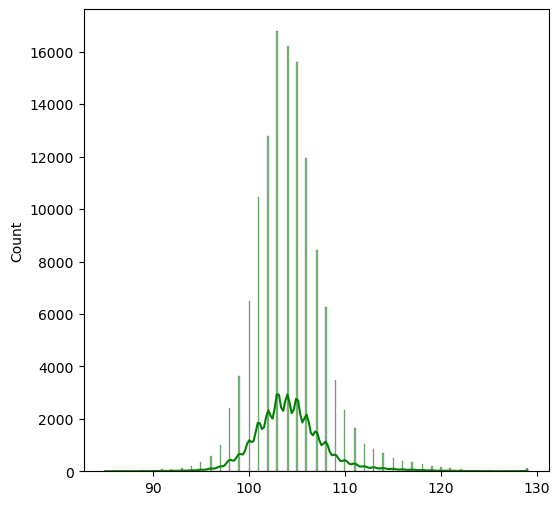

In [42]:
_,ax = plt.subplots(figsize=(6,6))
# sns.histplot(tar[:,...,0].reshape(-1,), color='g', label='Nuc')
# sns.histplot(tar[:,...,1].reshape(-1,), color='r', label='Tub')

sns.histplot(tar[:,::10,::10,0].reshape(-1,), color='g', kde=True)

In [43]:
# from disentangle.data_loader.schroff_rawdata_loader import mito_channel_fnames
# from disentangle.core.tiff_reader import load_tiff
# import seaborn as sns

# fpaths = [os.path.join(datapath, x) for x in mito_channel_fnames()]
# fpath = fpaths[0]
# print(fpath)
# img = load_tiff(fpaths[0])
# temp = img.copy()
# sns.histplot(temp[:,:,::10,::10].reshape(-1,))
# plt.hist(temp[:,:,::10,::10].reshape(-1,),bins=100)

0


/home/ashesh.ashesh/code/Disentangle/disentangle/analysis/plot_error_utils.py:52: UserWarning: Overwriting the cmap 'shiftedcmap' that was already in the registry.
  matplotlib.colormaps.register(cmap=newcmap, force=True)


(3, 2048, 2048, 2)

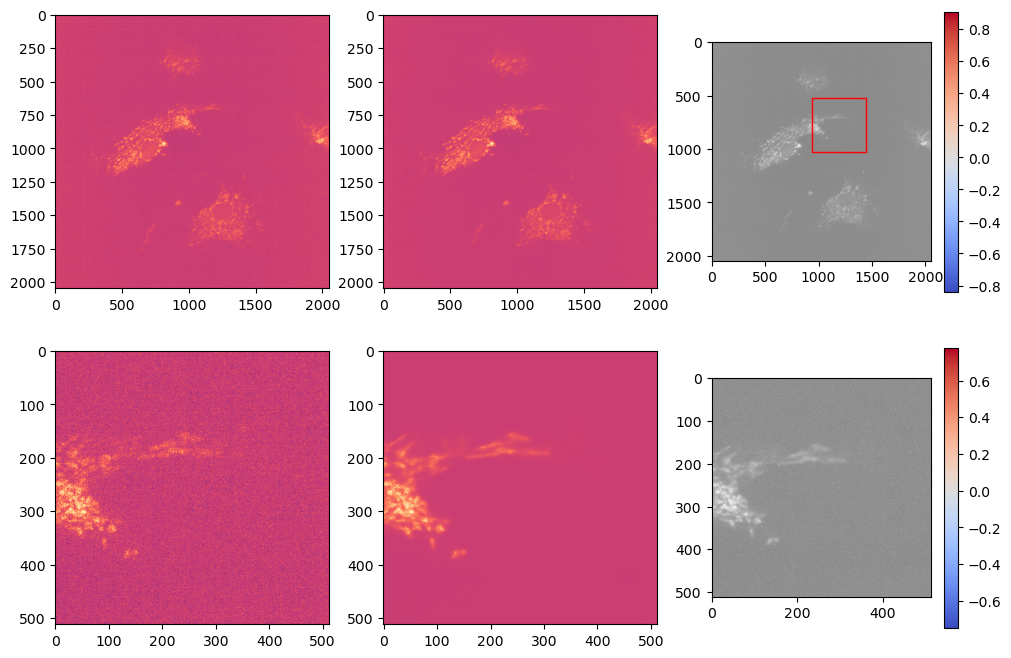

In [44]:
import matplotlib.patches as patches
import matplotlib
from disentangle.analysis.plot_error_utils import plot_error

_,ax = plt.subplots(figsize=(12,8),ncols=3,nrows=2)
idx = np.random.randint(len(pred))
print(idx)
ax[0,0].imshow(tar_normalized[idx,...,0], cmap='magma')
ax[0,1].imshow(pred[idx,:,:,0], cmap='magma')
plot_error(tar_normalized[idx,...,0], 
           pred[idx,:,:,0], 
           cmap = matplotlib.cm.coolwarm, 
           ax = ax[0,2], max_val = None)

cropsz = 512
h_s = np.random.randint(0, tar_normalized.shape[1] - cropsz)
h_e = h_s + cropsz
w_s = np.random.randint(0, tar_normalized.shape[2] - cropsz)
w_e = w_s + cropsz

ax[1,0].imshow(tar_normalized[idx,h_s:h_e,w_s:w_e,0], cmap='magma')
ax[1,1].imshow(pred[idx,h_s:h_e,w_s:w_e,0], cmap='magma')
plot_error(tar_normalized[idx,h_s:h_e,w_s:w_e,0], 
           pred[idx,h_s:h_e,w_s:w_e,0], 
           cmap = matplotlib.cm.coolwarm, 
           ax = ax[1,2], max_val = None)



clean_ax(ax[0,3:])

# Add rectangle to the region
rect = patches.Rectangle((w_s, h_s), w_e-w_s, h_e-h_s, linewidth=1, edgecolor='r', facecolor='none')
ax[0,2].add_patch(rect)
# plt.colorbar()
pred.shape

In [45]:
# ch1_pred_unnorm = pred[...,0]*sep_std[...,0].cpu().numpy() + sep_mean[...,0].cpu().numpy()
# ch2_pred_unnorm = pred[...,1]*sep_std[...,1].cpu().numpy() + sep_mean[...,1].cpu().numpy()
pred_unnorm = pred*sep_std + sep_mean

In [46]:
rmse =np.sqrt(((pred - tar_normalized)**2).reshape(len(pred),-1).mean(axis=1))
rmse = np.round(rmse,3)
psnr = avg_psnr(tar_normalized[...,0], pred[...,0]) 
rinv_psnr = avg_range_inv_psnr(tar_normalized[...,0], pred[...,0])
ssim_mean, ssim_std = avg_ssim(tar[...,0], pred_unnorm[...,0])

In [47]:
print(f'{DataSplitType.name(eval_datasplit_type)}_P{custom_image_size}_G{image_size_for_grid_centers}_M{mmse_count}_Sk{ignored_last_pixels}')
print('Rec Loss',model.denoise_channel, np.round(rec_loss.mean(),3) )
print('RMSE', model.denoise_channel, np.mean(rmse).round(3))
print('PSNR',model.denoise_channel, psnr)
print('RangeInvPSNR',model.denoise_channel, rinv_psnr)
print('SSIM',model.denoise_channel, round(ssim_mean,3),'±',round(ssim_std,4))
print()

Test_P64_G32_M5_Sk0
Rec Loss Ch2 0.256
RMSE Ch2 0.775
PSNR Ch2 25.27
RangeInvPSNR Ch2 25.27
SSIM Ch2 0.27 ± 0.033



In [48]:
from disentangle.data_loader.two_tiff_rawdata_loader import get_train_val_data
import ml_collections
data_config = ml_collections.ConfigDict()
data_config.ch1_fname = 'actin-60x-noise2-highsnr.tif'
data_config.ch2_fname = 'mito-60x-noise2-highsnr.tif'
highres_data = get_train_val_data(data_dir, data_config, 
                   eval_datasplit_type, 
                   config.training.val_fraction, 
                   config.training.test_fraction)

highres_input = np.mean(highres_data, axis=-1, keepdims=True)

if model.denoise_channel == 'Ch1':
    highres_data= highres_data[...,:1]
elif model.denoise_channel == 'Ch2':
    highres_data= highres_data[...,1:]
elif model.denoise_channel == 'input':
    highres_data = highres_input



Loading from /group/jug/ashesh/data//ventura_gigascience Channel1: /group/jug/ashesh/data//ventura_gigascience/actin-60x-noise2-highsnr.tif,/group/jug/ashesh/data//ventura_gigascience/mito-60x-noise2-highsnr.tif, Mode:Test


In [49]:
print(f'{DataSplitType.name(eval_datasplit_type)}_P{custom_image_size}_G{image_size_for_grid_centers}_M{mmse_count}_Sk{ignored_last_pixels}')
print('PSNR on Highres', model.denoise_channel, avg_range_inv_psnr(highres_data[...,0], pred_unnorm[...,0]))
ssim_hres_mean, ssim_hres_std = avg_ssim(highres_data[...,0], pred_unnorm[...,0])
print('SSIM on Highres', model.denoise_channel, np.round(ssim_hres_mean,3), '±', np.round(ssim_hres_std,3))


Test_P64_G32_M5_Sk0
PSNR on Highres Ch2 32.59
SSIM on Highres Ch2 0.854 ± 0.056


1


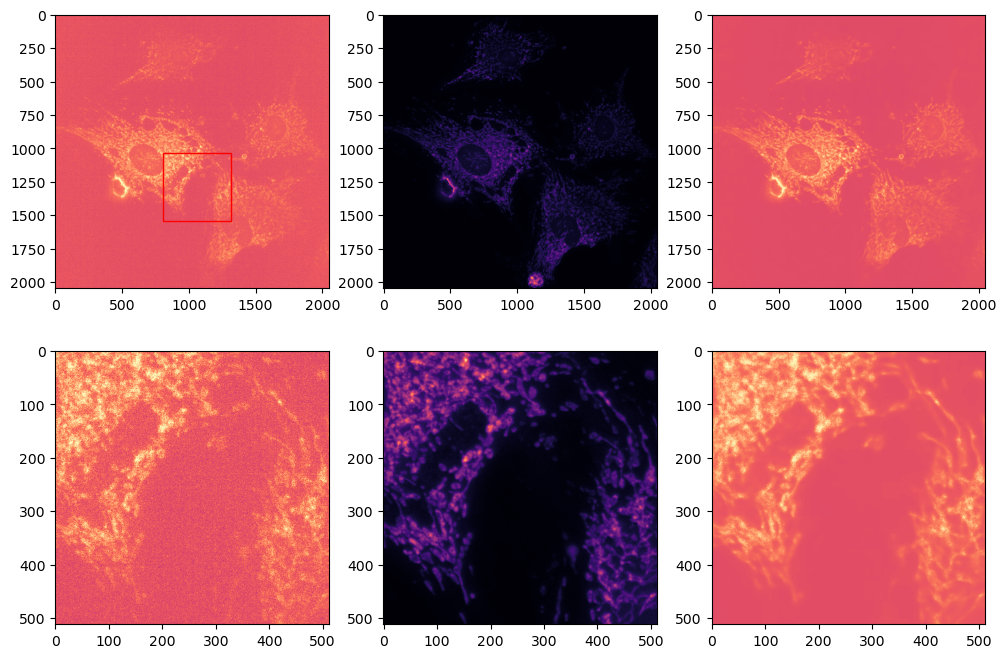

In [50]:
_,ax = plt.subplots(figsize=(12,8),ncols=3,nrows=2)
idx = np.random.randint(len(pred))
print(idx)
ax[0,0].imshow(tar_normalized[idx,...,0], cmap='magma')
ax[0,1].imshow(highres_data[idx,...,0], cmap='magma')
ax[0,2].imshow(pred_unnorm[idx,...,0], cmap='magma')
cropsz = 512
h_s = np.random.randint(0, tar_normalized.shape[1] - cropsz)
h_e = h_s + cropsz
w_s = np.random.randint(0, tar_normalized.shape[2] - cropsz)
w_e = w_s + cropsz

ax[1,0].imshow(tar_normalized[idx,h_s:h_e,w_s:w_e,0], cmap='magma')
ax[1,1].imshow(highres_data[idx,h_s:h_e,w_s:w_e,0], cmap='magma')
ax[1,2].imshow(pred_unnorm[idx,h_s:h_e,w_s:w_e,0], cmap='magma')
# Add rectangle to the region
rect = patches.Rectangle((w_s, h_s), w_e-w_s, h_e-h_s, linewidth=1, edgecolor='r', facecolor='none')
ax[0,0].add_patch(rect)


In [51]:
# break here

In [52]:
# inspect the correctness of the data. what is channel 1 what is channel 2. 
# inspect the sampling property. 
# document the results. 


In [53]:
# Test_P64_G32_M1_Sk32
# Rec Loss 1.15
# RMSE 0.839 0.038 0.439
# PSNR 21.52 42.86
# RangeInvPSNR 21.52 42.88
# SSIM 0.427 0.819 ± 0.0

In [54]:
# Test_P64_G32_M1_Sk32
# Rec Loss -0.45
# RMSE 0.218 0.15 0.184
# PSNR 31.69 31.57
# RangeInvPSNR 31.7 31.6
# SSIM 0.757 0.658 ± 0.0033

In [55]:
!ls -lhrt Act*

ls: cannot access 'Act*': No such file or directory


In [56]:
if config.model.model_type == ModelType.LadderVaeSemiSupervised:
    from disentangle.analysis.plot_utils import add_pixel_kde
    inset_rect=[0.1,0.1,0.4,0.2]
    min_labelsize = 15

    nimgs=5
    crp_sz = 400
    img_sz = 8

    _,ax = plt.subplots(figsize=(4*img_sz,img_sz*nimgs),ncols=5,nrows=nimgs)
    clean_ax(ax[1:,])
    clean_ax(ax[:,1:])
    img_idx_list = np.random.permutation(np.arange(len(tar1)))[:nimgs] #[19,23,15,18,4] # 
    for ax_idx in range(nimgs):
        img_idx = img_idx_list[ax_idx]
        overlapping_pred = pred1[img_idx] + pred2[img_idx]
        overlapping_min = min(tar1[img_idx].min(),overlapping_pred.min())
        overlapping_max = max(tar1[img_idx].max(),overlapping_pred.max())

        ax[ax_idx,0].imshow(tar1[img_idx])#,vmin=overlapping_min,vmax=overlapping_max)
        ax[ax_idx,1].imshow(overlapping_pred)#,vmin=overlapping_min,vmax=overlapping_max)

        ch1_min = tar2[img_idx].min()#,pred1[img_idx].min())
        ch1_max = tar2[img_idx].max()#,pred1[img_idx].max())
        ax[ax_idx,2].imshow(tar2[img_idx])#,vmin=ch1_min,vmax=ch1_max)
        ax[ax_idx,3].imshow(pred1[img_idx])#,vmin=ch1_min,vmax=ch1_max)

        ax[ax_idx,4].imshow(pred2[img_idx])
        ax[ax_idx,0].set_ylabel(f'{img_idx}',fontsize=min_labelsize)

        # add_pixel_kde(ax[ax_idx,1],
        #               inset_rect,
        #               tar1 [img_idx],
        #               data2 =overlapping_pred,
        #              min_labelsize=min_labelsize)
        
        # add_pixel_kde(ax[ax_idx,3],
        #               inset_rect,
        #               tar2 [img_idx],
        #               data2 =pred1[img_idx],
        #              min_labelsize=min_labelsize)
        

    ax[0,0].set_title('Inp')
    ax[0,1].set_title('Recons')
    ax[0,2].set_title('GT 1')
    ax[0,3].set_title('Pred 1')
    ax[0,4].set_title('Pred 2')

#

### To save to tiff file.

In [57]:
# ch1_pred_unnorm = pred[...,0]*sep_std[...,1].cpu().numpy() + sep_mean[...,1].cpu().numpy()
# input_pred_unnorm = pred[...,2]*sep_std[...,0].cpu().numpy() + sep_mean[...,0].cpu().numpy()
# ch2_pred_unnorm = input_pred_unnorm - ch1_pred_unnorm
# ch2_pred_unnorm = pred[...,1]*sep_std[...,1].cpu().numpy() + sep_mean[...,1].cpu().numpy() #ch2_pred_unnorm - ch2_pred_unnorm.min()

# ch1_pred_unnorm = ch1_pred_unnorm.astype(np.int32)
# input_pred_unnorm = input_pred_unnorm.astype(np.int32)
# ch2_pred_unnorm = ch2_pred_unnorm.astype(np.int32)

# data = np.concatenate([val_dset._data[:,:480,:480], ch1_pred_unnorm[...,None],
# ch2_pred_unnorm[...,None], input_pred_unnorm[...,None]],
# axis=-1)

# import tifffile
# tifffile.imwrite("prediction2.tif", 
# np.swapaxes(data[:,None],1,4)[...,0].astype(np.uint16),
# imagej=True, 
# #  metadata={ 'axes': 'ZYXC'}, 
#  )

Showing for 5066


IndexError: index 1 is out of bounds for axis 0 with size 1

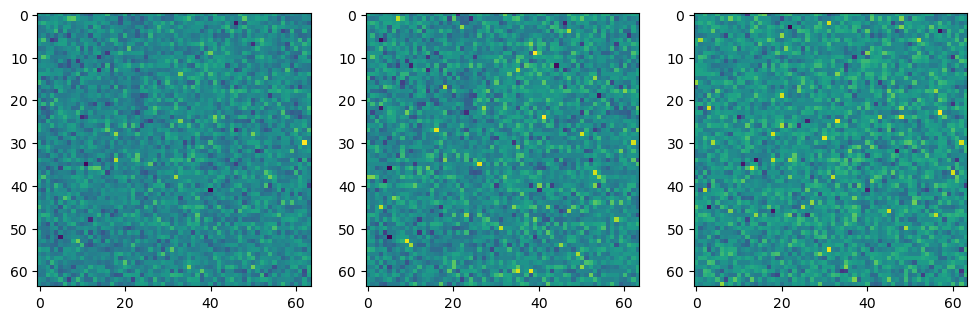

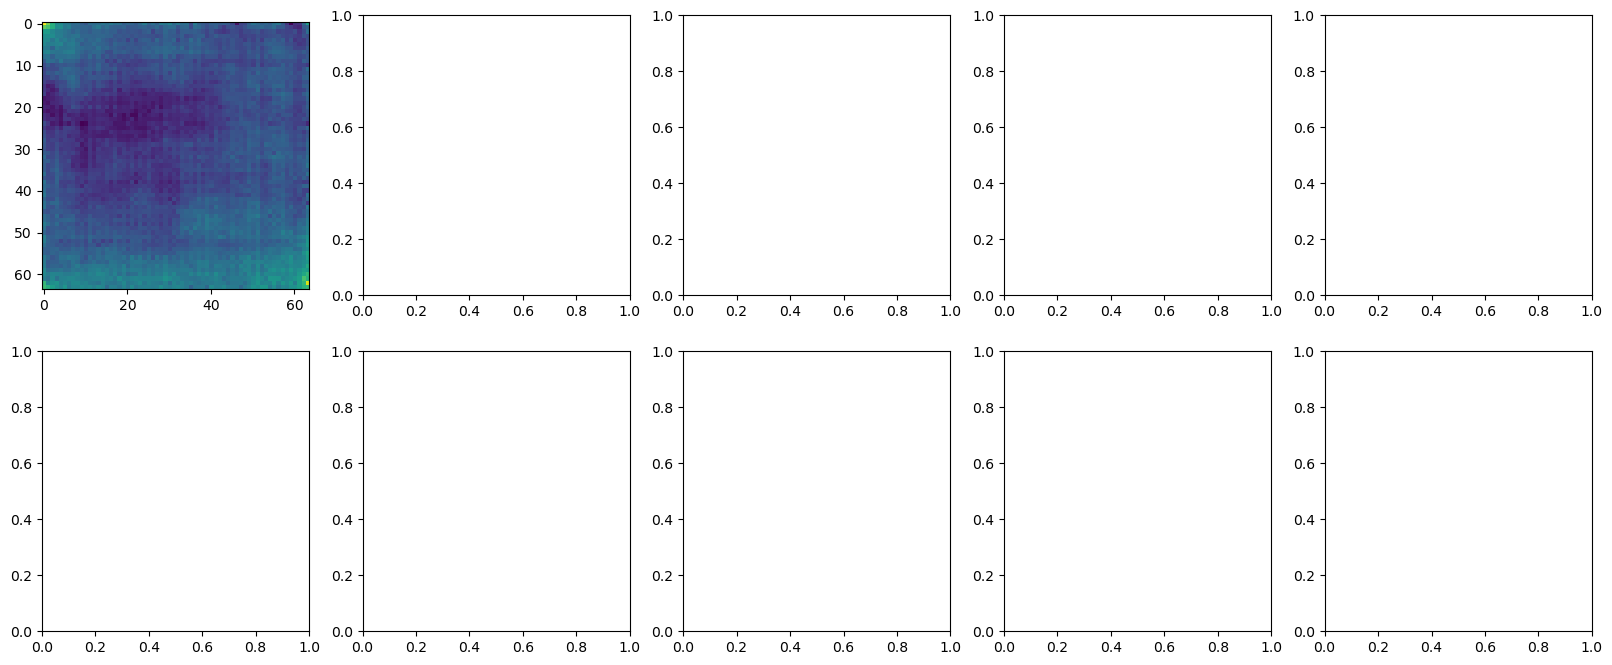

In [58]:
def show_for_one(idx):
    print(f'Showing for {idx}')
    with torch.no_grad():
        inp, tar = val_dset[idx]

        inp = torch.Tensor(inp[None])
        tar = torch.Tensor(tar[None])
        inp = inp.cuda()
        x_normalized = model.normalize_input(inp)
        tar = tar.cuda()
        tar_normalized = model.normalize_target(tar)

        recon_img_list = []
        for _ in range(5):
            if config.model.model_type == ModelType.UNet:
                recon_normalized = model(x_normalized)
                imgs = recon_normalized
            elif config.model.model_type == ModelType.LadderVaeSemiSupervised:
                out, td_data = model(x_normalized)
                rec_loss, imgs = model.get_reconstruction_loss(out,
                                                               x_normalized,
                                                               tar_normalized,
                                                               return_predicted_img=True)
            else:
                recon_normalized, td_data = model(x_normalized)
                rec_loss, imgs = model.get_reconstruction_loss(recon_normalized, tar_normalized,
                                                               return_predicted_img=True)
            recon_img_list.append(imgs.cpu().numpy()[0])

    _,ax = plt.subplots(figsize=(12,4),ncols=3)
    ax[0].imshow(inp[0,0].cpu().numpy())
    ax[1].imshow(tar[0,0].cpu().numpy())
    if tar.shape[1] ==2:
        ax[2].imshow(tar[0,1].cpu().numpy())

    _,ax = plt.subplots(figsize=(20,8),ncols=5,nrows=2)
    for i in range(5):
        ax[0,i].imshow(recon_img_list[i][0])
        ax[1,i].imshow(recon_img_list[i][1])

show_for_one(np.random.randint(len(val_dset)))

## Creating tiff file

In [ ]:
rdate,rconfig,rid = ckpt_dir.split("/")[-3:]
fname_prefix = rdate + '-' + rconfig.replace('-','')[:-2] + '-' + rid
fname_prefix

'2311-D16M3S0-85'

In [ ]:
from skimage.io import imsave
import numpy as np
pred_unnorm = np.concatenate([ch1_pred_unnorm[...,None],
                              ch2_pred_unnorm[...,None]],
                              axis=-1)
for ch_idx in [0,1]:
    tif_fname = f'{fname_prefix}_P{custom_image_size}_G{image_size_for_grid_centers}_M{mmse_count}_Sk{ignored_last_pixels}_C{ch_idx}.tif'
    tif_fpath=os.path.join('paper_tifs',tif_fname)
    if config.data.data_type in [DataType.CustomSinosoid, DataType.CustomSinosoidThreeCurve]:
        output = np.concatenate([
                            pred_unnorm[None,:50,...,ch_idx],tar[None,:50,...,ch_idx],
        ],axis=0)
    else:
        output = np.concatenate([
                                pred_unnorm[:1,...,ch_idx],tar[:1,...,ch_idx],
        ],axis=0)
    imsave(tif_fpath,output,plugin='tifffile')
    print(tif_fpath)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ashesh.ashesh/code/Disentangle/disentangle/notebooks/paper_tifs/2311-D16M3S0-85_P64_G32_M1_Sk44_C0.tif'

In [ ]:
! ls -lhrt paper_tifs/2211-D8M3S0-*

In [ ]:
# !ls paper_tifs/2211-D3M3S0-0_P64_G*

In [ ]:
idx = np.random.randint(len(val_dset))
inp, tar = val_dset[idx]

In [ ]:
if len(inp) > 1:
    _,ax = plt.subplots(figsize=(10,2.5),ncols=4)
    ax[0].imshow(inp[0])
    ax[1].imshow(inp[1])
    ax[2].imshow(inp[2])
    ax[3].imshow(inp[3])

In [ ]:
tar_unnorm.shape

In [ ]:
# _,ax = plt.subplots(figsize=(10,10))
# tmp_data =tar_unnorm[idx,:,:,1]
# q = np.quantile(tmp_data,0.95)
# tmp_data[tmp_data >q] = q
# plt.imshow(tmp_data)

In [ ]:
pred_unnorm.min()

In [ ]:
idx =  np.random.randint(len(tar_unnorm))
print(idx)
_,ax = plt.subplots(figsize=(20,20),ncols=2,nrows=2)
ax[0,0].set_title('Channel 1',size=20)
ax[0,1].set_title('Channel 2',size=20)
ax[0,0].set_ylabel('Target',size=20)
ax[1,0].set_ylabel('Predictions',size=20)
ax[0,0].imshow(tar_unnorm[idx,:,:,0])
ax[0,1].imshow(tar_unnorm[idx,:,:,1])
ax[1,0].imshow(pred_unnorm[idx,:,:,0])
ax[1,1].imshow(pred_unnorm[idx,:,:,1])

In [ ]:
idx =  0#np.random.randint(len(tar_unnorm))
print(idx)
_,ax = plt.subplots(figsize=(20,30),ncols=2,nrows=3)
ax[0,0].set_title('Target',size=20)
ax[0,1].set_title('Prediction',size=20)
ax[0,0].set_ylabel('Mixed Input',size=20)
ax[1,0].set_ylabel('Channel 1',size=20)
ax[2,0].set_ylabel('Channel 2',size=20)
sz = 400
ax[0,0].imshow(np.mean(tar_unnorm[idx, 1000:1000+sz,400:400+sz], axis=2))
ax[0,1].imshow(np.mean(pred_unnorm[idx,1000:1000+sz,400:400+sz], axis=2))

ax[1,0].imshow(tar_unnorm[idx, 1000:1000+sz,400:400+sz,0],vmax=126,vmin=88)
ax[1,1].imshow(pred_unnorm[idx,1000:1000+sz,400:400+sz,0], vmax=126,vmin=88)

ax[2,0].imshow(tar_unnorm[idx, 1000:1000+sz,400:400+sz,1],vmax=126,vmin=78)
ax[2,1].imshow(pred_unnorm[idx,1000:1000+sz,400:400+sz,1],vmax=126,vmin=78)

In [ ]:
tar_unnorm[idx, 1000:1500,400:900,0].std()

In [ ]:
pred_unnorm[idx,1000:1500,400:900,0].std()

In [ ]:
idx =  np.random.randint(len(tar_unnorm))
print(idx)
_,ax = plt.subplots(figsize=(20,30),ncols=2,nrows=3)
ax[0,0].set_title('Target',size=20)
ax[0,1].set_title('Prediction',size=20)
ax[0,0].set_ylabel('Mixed Input',size=20)
ax[1,0].set_ylabel('Channel 1',size=20)
ax[2,0].set_ylabel('Channel 2',size=20)

ax[0,0].imshow(np.mean(tar_unnorm[idx, 1000:1500,400:900], axis=2))
ax[0,1].imshow(np.mean(pred_unnorm[idx,1000:1500,400:900], axis=2))

ax[1,0].imshow(tar_unnorm[idx, 1000:1500,400:900,0])
ax[1,1].imshow(pred_unnorm[idx,1000:1500,400:900,0])

ax[2,0].imshow(tar_unnorm[idx, 1000:1500,400:900,1])
ax[2,1].imshow(pred_unnorm[idx,1000:1500,400:900,1])

In [ ]:
break here

## Comparing PSNR with high res data. 

In [ ]:
from disentangle.core.data_split_type import  get_datasplit_tuples

In [ ]:
if eval_datasplit_type == DataSplitType.Val:
    N = len(pred1)/config.training.val_fraction
elif eval_datasplit_type == DataSplitType.Test:
    N = len(pred1)/config.training.test_fraction
train_idx,val_idx,test_idx = get_datasplit_tuples(config.training.val_fraction,config.training.test_fraction,N,
                                          starting_train=False)

In [ ]:
from disentangle.core.tiff_reader import load_tiff

In [ ]:
highres_actin = load_tiff('/home/ashesh.ashesh/data/ventura_gigascience/actin-60x-noise2-highsnr.tif')[...,None]
highres_mito = load_tiff('/home/ashesh.ashesh/data/ventura_gigascience/mito-60x-noise2-highsnr.tif')[...,None]

if eval_datasplit_type == DataSplitType.Val:
    highres_data = np.concatenate([highres_actin[val_idx[0]:val_idx[1]],
                                   highres_mito[val_idx[0]:val_idx[1]]],
                                  axis=-1).astype(np.float32)
elif eval_datasplit_type == DataSplitType.Test:
    highres_data = np.concatenate([highres_actin[test_idx[0]:test_idx[1]],
                                   highres_mito[test_idx[0]:test_idx[1]]],
                                  axis=-1).astype(np.float32)

In [ ]:
thresh = np.quantile(highres_data,config.data.clip_percentile)
highres_data[highres_data > thresh]=thresh
    

In [ ]:
_,ax = plt.subplots(figsize=(8,8),ncols=2,nrows=2)
ax[0,0].imshow(tar_unnorm[5,...,0])
ax[0,1].imshow(highres_data[5,...,0])
ax[1,0].imshow(tar_unnorm[8,...,1])
ax[1,1].imshow(highres_data[8,...,1])


In [ ]:
print('PSNR with HighRes', avg_psnr(highres_data[...,0], pred1),avg_psnr(highres_data[...,1], pred2))
print('RangeInvPSNR with HighRes', avg_range_inv_psnr(highres_data[...,0], pred1), 
      avg_range_inv_psnr(highres_data[...,1], pred2))


In [ ]:
# RangeInvPSNR with HighRes 16.82 18.33


In [ ]:
tar_1_tmp.dtype

In [ ]:
from disentangle.core.psnr import fix_range, zero_mean
def fix_range_with_highresdata(pred,tar):
    pred_1_tmp = torch.Tensor(pred.reshape(len(pred),-1))
    tar_1_tmp = torch.Tensor(tar.reshape(len(tar),-1))
    pred_1_tmp = zero_mean(pred_1_tmp)
    tar_1_tmp = zero_mean(tar_1_tmp)
#     import pdb;pdb.set_trace()
    tar_1_tmp = tar_1_tmp / torch.std(tar_1_tmp, dim=1, keepdim=True)
    
    pred_1_tmp = fix_range(tar_1_tmp,pred_1_tmp)
    pred_1_tmp = pred_1_tmp.reshape_as(torch.Tensor(pred))
    tar_1_tmp = tar_1_tmp.reshape_as(torch.Tensor(pred))
    return pred_1_tmp, tar_1_tmp

In [ ]:
pred1_tmp, tar1_tmp = fix_range_with_highresdata(pred1, highres_data[...,0])
pred2_tmp, tar2_tmp = fix_range_with_highresdata(pred2, highres_data[...,1])

In [ ]:
ssim1_mean, ssim1_std = avg_ssim(tar1_tmp.numpy(), pred1_tmp.numpy())
ssim2_mean, ssim2_std = avg_ssim(tar2_tmp.numpy(), pred2_tmp.numpy())
print(ssim1_mean, ssim2_mean)

In [ ]:
_,ax = plt.subplots(figsize=(8,4),ncols=2)
ax[0].imshow(pred_1_tmp[0])
ax[1].imshow(tar_1_tmp[0])


In [ ]:
break here.

## Inspecting the performance on grid boundaries.


In [ ]:
from disentangle.analysis.stitch_prediction import stitched_prediction_mask


skip_boundary_pixel_count = 0
for sk_c in [1,16,32,48,56]:
    mask = stitched_prediction_mask(val_dset, 
                                (val_dset._img_sz,val_dset._img_sz), 
                                skip_boundary_pixel_count, 
                                sk_c)
    mask = ignore_pixels(mask)
    psnr1, psnr2 = compute_masked_psnr(mask, tar1,tar2,pred1,pred2)
    print(f'[Pad:{val_dset.per_side_overlap_pixelcount()}] SkipCentral', sk_c,
          psnr1,psnr2)

In [ ]:
plt.imshow(mask[0,:,:,0])

## Inspecting the performance on central regions

In [ ]:
skip_central_pixel_count = 0

for sk_b in [1,8,16,20,24]:
    mask = stitched_prediction_mask(val_dset, 
                                (val_dset._img_sz,val_dset._img_sz), 
                                sk_b, 
                                skip_central_pixel_count)
    mask = ignore_pixels(mask)
    psnr1, psnr2 = compute_masked_psnr(mask, tar1,tar2,pred1,pred2)
    print(f'[Pad:{val_dset.per_side_overlap_pixelcount()}] SkipBoundary', sk_b, psnr1,psnr2)

In [ ]:
plt.imshow(mask[0,:,:,0])

In [ ]:
# for w in range(2,202,25):
#     print(f'RangeInvPSNR but skipping {w}', avg_range_inv_psnr(np.copy(tar1[:,w:-w,w:-w]), 
#                                                                np.copy(pred1[:,w:-w,w:-w])),
    
#                                             avg_range_inv_psnr(np.copy(tar2[:,w:-w,w:-w]), 
#                                                                np.copy(pred2[:,w:-w,w:-w]).copy()))

In [ ]:
h = 1200
w = 1200
sz = 512
x = tar_unnorm[:1,h:h+sz,w:w+sz].mean(axis=3)

In [ ]:
p_count = 32
y1 = np.pad(x,np.array([[0, 0], [p_count, p_count], [p_count, p_count]]))
y2 = np.pad(x,np.array([[0, 0], [p_count, p_count], [p_count, p_count]]), constant_values=237)
y3 = np.pad(x,np.array([[0, 0], [p_count, p_count], [p_count, p_count]]), mode='linear_ramp', end_values=237)
y4 = np.pad(x,np.array([[0, 0], [p_count, p_count], [p_count, p_count]]),mode='reflect')


In [ ]:
np.quantile(x, [0,0.05, 0.1])

In [ ]:
_,ax = plt.subplots(figsize=(16,4),ncols=4)
ax[0].imshow(y1[0], )
ax[1].imshow(y2[0], )
ax[2].imshow(y3[0], )
ax[3].imshow(y4[0], )

In [ ]:
_,ax = plt.subplots(figsize=(20,5),ncols=2)
sns.histplot(tar_unnorm[0,:,:,0].reshape(-1,),ax=ax[0])
sns.histplot(tar_unnorm[0,:,:,1].reshape(-1,),ax=ax[1])

In [ ]:
_,ax = plt.subplots(figsize=(20,5),ncols=2)
sns.histplot(tar_unnorm[-1,:,:,0].reshape(-1,),ax=ax[0])
sns.histplot(tar_unnorm[-1,:,:,1].reshape(-1,),ax=ax[1])

In [ ]:
_,ax = plt.subplots(figsize=(20,5),ncols=2)
sns.histplot(pred_unnorm[0,:,:,0].reshape(-1,),ax=ax[0])
sns.histplot(pred_unnorm[0,:,:,1].reshape(-1,),ax=ax[1])

In [ ]:
import matplotlib.ticker as ticker
# import seaborn.apionly as sns

_,ax = plt.subplots(figsize=(20,4))
sns.histplot(tar_unnorm[-1,:,:].mean(axis=2).reshape(-1,))
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

In [ ]:
tar_unnorm[-1,:,:].shape

In [ ]:
# inp, tar = val_dset[11060]

In [ ]:
# _,ax = plt.subplots(figsize=(16,4),ncols=4)
# ax[0].imshow(inp[0])
# ax[1].imshow(inp[1])
# ax[2].imshow(inp[2])
# ax[3].imshow(inp[3])

In [ ]:
# _,ax = plt.subplots(figsize=(8,4),ncols=2)
# ax[0].imshow(tar[0])
# ax[1].imshow(tar[1])

## Inspecting the difference in behaviour when different sized inputs are passed. 

In [ ]:
import seaborn as sns
def compute_centered_diff(big,small):
    pad = (big.shape[-1] - small.shape[-1])//2
#     import pdb;pdb.set_trace()
    return big[:,:,pad:-pad,pad:-pad] - small
 
old_img_sz = val_dset.get_img_sz()
val_dset.set_img_sz(128)
inp2, tar2 = val_dset[10000]
with torch.no_grad():
    bu_values2 = model.bottomup_pass(torch.Tensor(inp2[None]).cuda())

val_dset.set_img_sz(256)
inp3, tar3 = val_dset[10000]
with torch.no_grad():
    bu_values3 = model.bottomup_pass(torch.Tensor(inp3[None]).cuda())

diff = (bu_values2[0] - bu_values3[0][:,:,32:-32,32:-32]).cpu().numpy()
sns.histplot(diff.reshape(-1,))

##LOOKING AT bu_values
idx=1
diff = compute_centered_diff(bu_values3[idx],bu_values2[idx]).cpu().numpy()
_,ax =plt.subplots(figsize=(10,10))
sns.heatmap(diff[0,0])

## Looking at the difference in prediction.
with torch.no_grad():
    out2,_ = model(torch.Tensor(inp2[None,]).cuda())
    out3,_ = model(torch.Tensor(inp3[None,]).cuda())
    img2 = get_img_from_forward_output(out3,model)
    img3 = get_img_from_forward_output(out2,model)
diff = compute_centered_diff(img2,img3)
_,ax =plt.subplots(figsize=(10,10))
sns.heatmap(diff[0,1].cpu().numpy())
val_dset.set_img_sz(old_img_sz)


In [ ]:
from disentangle.core.tiff_reader import load_tiff

In [ ]:
img = load_tiff('/home/ashesh.ashesh/data/ventura_gigascience/actin-60x-noise2-highsnr.tif')

In [ ]:
img.shape

In [ ]:
_,ax = plt.subplots(figsize=(20,5),ncols=4)
ax[0].imshow(img[0])
ax[1].imshow(img[1])
ax[2].imshow(img[2])
ax[3].imshow(img[3])

In [ ]:
img2 =load_tiff('/home/ashesh.ashesh/data/microscopy/OptiMEM100x014.tif')

In [ ]:
img2.shape

In [ ]:
_,ax = plt.subplots(figsize=(20,5),ncols=4)
ax[0].imshow(img2[0,...,0])
ax[1].imshow(img2[1,...,0])
ax[2].imshow(img2[2,...,0])
ax[3].imshow(img2[3,...,0])

###### 

In [ ]:
inp, tar = val_dset[0]

In [ ]:
inp.shape

In [ ]:
# _,ax = plt.subplots(figsize=(3,3))
plt.imshow(tar[0])

In [ ]:
plt.imshow(inp[0])

In [ ]:
(0.436+0.810)/2